In [1]:
import ast
import os

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity

from scripts.create_embeddings_dataset import batch_create_images_dataset, create_audio_dataset, \
    batch_create_audio_embeddings

/home/mulham/.virtualenvs/janus-ubuntu/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/mulham/.virtualenvs/janus-ubuntu/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/home/mulham/.virtualenvs/janus-ubuntu/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Images dataset

In [8]:
output_dir = "../images"

In [ ]:
batch_create_images_dataset(images_dir='../images/imagesf2', output_dir="../images", batch_size=10, count=1000,
                            offset=4500)

In [9]:
batches = [pklf for pklf in os.listdir(output_dir) if "images_dataset" in pklf and pklf.endswith(".pkl")]
dfs = []
for batch in batches:
    dfs.append(pd.read_pickle(os.path.join(output_dir, batch)))

images_df = pd.concat(dfs, ignore_index=True)
images_df.drop_duplicates(subset=["image_path"], inplace=True)
images_df.to_pickle(os.path.join(output_dir, "images_dataset_concat.pkl"))

# Audio dataset

In [10]:
audio_dir = "../music/fma_small"
output_dir = "../music/"

In [ ]:
music_df = create_audio_dataset(audio_dir, output_path="../music/music_df.csv",count=10000)
music_df.head()

In [ ]:
batch_create_audio_embeddings(audio_df_path="../music/music_df.csv", output_dir="../music", batch_size=25, count=2000, offset=1700)

In [11]:
batches = [pklf for pklf in os.listdir(output_dir) if "audio_dataset" in pklf and pklf.endswith(".pkl")]
dfs = []
for batch in batches:
    dfs.append(pd.read_pickle(os.path.join(output_dir, batch)))

music_df = pd.concat(dfs, ignore_index=True)
music_df.drop_duplicates(subset=["audio_path"], inplace=True)
music_df.to_pickle(os.path.join(output_dir, "audio_dataset_concat.pkl"))

# Match images and audio

In [38]:
music_dataset_path = "../music/audio_dataset_concat.pkl"
images_dataset_path = "../images/images_dataset_concat.pkl"

music_df = pd.read_pickle(music_dataset_path)
images_df = pd.read_pickle(images_dataset_path)

print("Images dataset size: ", len(images_df))
print("Audio dataset size: ", len(music_df))

Images dataset size:  41187
Audio dataset size:  7700


In [39]:
def match_datasets(image_embeddings_df: pd.DataFrame, music_embeddings_df: pd.DataFrame) -> pd.DataFrame:
    image_embeddings = image_embeddings_df[["embeddings"]]
    music_embeddings = music_embeddings_df[["embeddings"]]

    image_embeddings = np.array([np.array(e) for e in image_embeddings["embeddings"].tolist()])
    music_embeddings = np.array([np.array(e) for e in music_embeddings["embeddings"].tolist()])

    similarity_matrix = cosine_similarity(image_embeddings, music_embeddings)

    cost_matrix = 1 - similarity_matrix
    image_ind, music_ind = linear_sum_assignment(cost_matrix)

    matched_pairs = pd.DataFrame()
    matched_pairs["image_path"] = image_embeddings_df.iloc[image_ind]["image_path"].values
    matched_pairs["audio_path"] = music_embeddings_df.iloc[music_ind]["audio_path"].values
    matched_pairs["music_embedding"] = music_embeddings_df.iloc[music_ind]["embeddings"].values
    matched_pairs["image_embedding"] = image_embeddings_df.iloc[image_ind]["embeddings"].values
    matched_pairs["score"] = 1 - cost_matrix[image_ind, music_ind]

    return matched_pairs

In [40]:
matched_df = match_datasets(images_df, music_df)
matched_df.sort_values(by="score", ascending=False, inplace=True)
matched_df.reset_index(drop=True, inplace=True)

In [41]:
matched_df["image_path"] = matched_df["image_path"].str.replace("../images/", "", regex=False)
matched_df["audio_path"] = matched_df["audio_path"].str.replace("../music/", "", regex=False)

In [42]:
matched_df.head()

,image_path,audio_path,music_embedding,image_embedding,score
0,imagesf2/hans-holbein-the-younger_portrait-of-...,fma_small/017/017735.mp3,"[0.52044404, 0.19528687, -0.2770793, -0.164364...","[0.026447035, 0.01119647, 0.009961983, -0.0153...",0.529649
1,imagesf2/george-frederick-watts_eveleen-tennan...,fma_small\054\054626.mp3,"[0.7743074, -0.39134812, -0.7777392, -0.410989...","[-0.014325936, -0.008836512, 0.024141956, -0.0...",0.467572
2,imagesf2/zdislav-beksinski_untitled-17.jpg,fma_small\054\054621.mp3,"[0.78102607, -0.38051218, -0.7358792, -0.45647...","[-0.014325936, -0.008836512, 0.024141956, -0.0...",0.465413
3,imagesf2\alfred-sisley_willows-in-a-field-afte...,fma_small\017\017735.mp3,"[0.5204456, 0.19528715, -0.2770794, -0.1643646...","[-0.008363659, -0.001513008, 0.012816312, -0.0...",0.457331
4,imagesf2/gustave-moreau_the-muses-leaving-thei...,fma_small/104/104725.mp3,"[-0.19922774, 0.82050055, -0.27865136, 0.25609...","[0.023505654, 0.0033783985, -0.021242058, -0.0...",0.451257


In [46]:
filtered_df = matched_df[matched_df["score"] < 0.15]
val_df = filtered_df[filtered_df["score"] > 0.14]


In [47]:
len(val_df)

182

In [49]:
val_df.to_pickle("matched_dataset_0_14.pkl")

In [2]:
filtered_df = pd.read_pickle("matched_dataset_0_15.pkl")

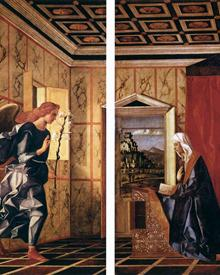

ValueError: could not convert string to float: '../music/fma_small\\006\\006406.mp3'

In [33]:
t = filtered_df[filtered_df["audio_path"].str.contains("006406", na=False)].iloc[1]
image_path = os.path.join("../images", t["image_path"].replace("\\","/"))
audio_path = os.path.join("../music", t["audio_path"])

# Display the image
image = Image.open(image_path)
display(image)

display(Audio(audio_path, autoplay=True, rate=44100))

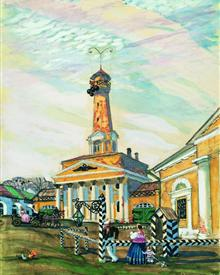

In [22]:
# view image frim image_path and play audio path from filtered_df
from PIL import Image
from IPython.display import display, Audio

# Example: View the first image and play the first audio
row = filtered_df.iloc[1600]
image_path = os.path.join("../images", row["image_path"].replace("\\","/"))
audio_path = os.path.join("../music", row["audio_path"])

# Display the image
image = Image.open(image_path)
display(image)

# Play the audio
display(Audio(audio_path, autoplay=True))

In [6]:
row = filtered_df.iloc[1600]
embeds = row["music_embedding"]

In [12]:
print(embeds.shape)
print(embeds.max())
print(embeds.min())
print(embeds.mean())
# get norm
np.linalg.norm(embeds)

(1024,)
2.7631116
-2.4441829
-0.007063632


np.float32(15.220716)

In [13]:

import numpy as np

# Generate a random array
random_array = np.random.uniform(-3, 3, 1024)

# Scale the array to have the desired norm
norm = np.linalg.norm(random_array)
scaled_array = random_array * (15 / norm)

# Verify the properties
print(f"Min: {scaled_array.min()}, Max: {scaled_array.max()}")
print(f"Norm: {np.linalg.norm(scaled_array)}")

In [26]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from torch import nn
from PIL import Image

class ImageAudioDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        current_path = os.getcwd()

        self.dataframe["image_path"] = self.dataframe["image_path"].apply(
            lambda x: os.path.abspath(
                os.path.join(current_path, "data/images/" + x.split("/images/")[-1].replace("\\", "/"))))

        self.dataframe["audio_path"] = self.dataframe["audio_path"].apply(
            lambda x: os.path.abspath(
                os.path.join(current_path, "data/music/" + x.split("/music")[-1].replace("\\", "/"))))
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx) -> dict:
        image_path = self.dataframe.iloc[idx]["image_path"]
        audio_path = self.dataframe.iloc[idx]["audio_path"]
        image_path = os.path.join("../images", image_path.replace("\\","/"))
        image = 1
        if self.transform:
            image = 1
        else:
            image = 1
            image = 1

        image_embedding = self.dataframe.iloc[idx]["image_embedding"]
        music_embedding = self.dataframe.iloc[idx]["music_embedding"]
        return {
            "audio_path": audio_path,
            "image": image,
            "music_embedding": music_embedding,
            "image_embedding": image_embedding,
        }


In [27]:

dataset = ImageAudioDataset(filtered_df)
loader = DataLoader(dataset, batch_size=5, shuffle=True,
                                  num_workers=4, pin_memory=True,)

In [37]:
val_df = filtered_df.sample(n=100, random_state=42)
val_indices = val_df.index

train_df = filtered_df.drop(val_indices)

print(f"Original DataFrame length: {len(filtered_df)}")
print(f"Training dataset length (derived from train_df): {len(train_df)}")
print(f"Validation dataset length (derived from val_df): {len(val_df)}")
print(f"Sum of train and val: {len(train_df) + len(val_df)}")

Original DataFrame length: 7183
Training dataset length (derived from train_df): 7083
Validation dataset length (derived from val_df): 100
Sum of train and val: 7183


# Training metrics graphs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


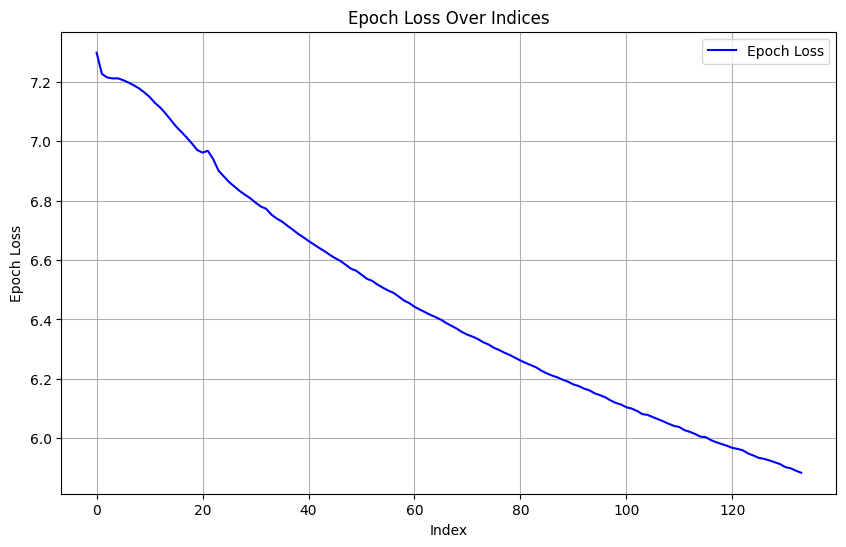

In [7]:
epoch_loss_df = pd.read_csv("../../data/training_res/epoch_loss_1.csv")


# Plot the epoch loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_loss_df.index, epoch_loss_df["epoch loss"], label="Epoch Loss", color="blue")
plt.xlabel("Index")
plt.ylabel("Epoch Loss")
plt.title("Epoch Loss Over Indices")
plt.legend()
plt.grid(True)
plt.savefig("plot_image.png")  #
plt.show()

In [13]:
len(epoch_loss_df)

134

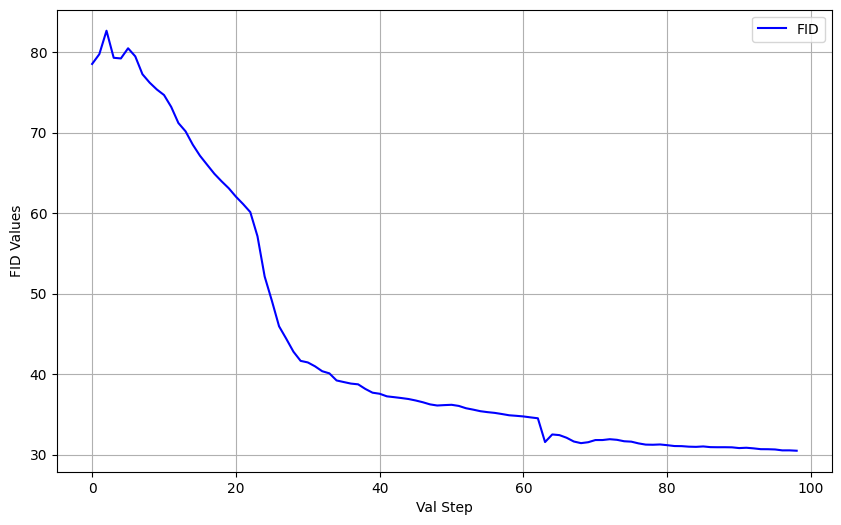

In [17]:
fid_df = pd.read_csv("../../data/training_res/fid_1.csv")


# Plot the epoch loss
plt.figure(figsize=(10, 6))
plt.plot(fid_df.index, fid_df["value"], label="FID", color="blue")
plt.xlabel("Val Step")
plt.ylabel("FID Values")
plt.legend()
plt.grid(True)
plt.savefig("fid_plot_image.png")  #
plt.show()

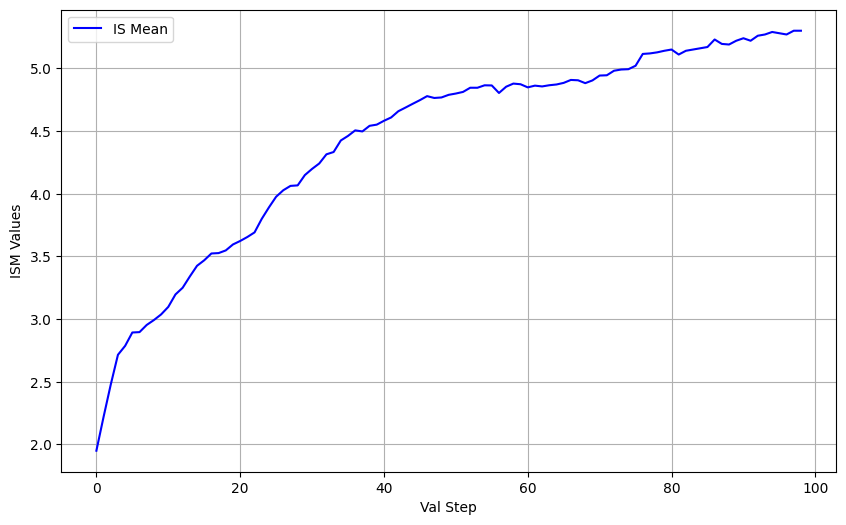

In [18]:
ismean_df = pd.read_csv("../../data/training_res/val_ism_1.csv")


# Plot the epoch loss
plt.figure(figsize=(10, 6))
plt.plot(ismean_df.index, ismean_df["value"], label="IS Mean", color="blue")
plt.xlabel("Val Step")
plt.ylabel("ISM Values")
plt.legend()
plt.grid(True)
plt.savefig("is_plot_image.png")  #
plt.show()